Load regression data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_california_housing
from scipy.stats import sem

housing = fetch_california_housing()
print(housing.feature_names)
print(housing.target_names)

X = housing.data
y = housing.target



['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
['MedHouseVal']


X, at this point, is a numpy matrix (just numbers)

In [2]:
X

array([[ 8.3252 , 41. , 6.98412698, ..., 2.55555556,
 37.88 , -122.23 ],
 [ 8.3014 , 21. , 6.23813708, ..., 2.10984183,
 37.86 , -122.22 ],
 [ 7.2574 , 52. , 8.28813559, ..., 2.80225989,
 37.85 , -122.24 ],
 ...,
 [ 1.7 , 17. , 5.20554273, ..., 2.3256351 ,
 39.43 , -121.22 ],
 [ 1.8672 , 18. , 5.32951289, ..., 2.12320917,
 39.43 , -121.32 ],
 [ 2.3886 , 16. , 5.25471698, ..., 2.61698113,
 39.37 , -121.24 ]])

The reason why Califronia X data is a numpy matrix, with no column names, is because the California dataset is inside the scikit-learn library, already prepared for use. However, in more real situations (like the assignment), we read the data from a file into a Pandas dataframe. In that case, columns would have names and values may not be numeric. In order to simulate a real situation more closely, we are going to put the names of the columns by hand (notice that if data is read from a file into a Pandas dataframe, as you do in the assignments, you don't have to do this)!!!

In [3]:
import pandas as pd
X = pd.DataFrame(X)
X.columns = housing.feature_names

Now, X is a dataframe with column names

In [4]:
X

MedInc HouseAge AveRooms AveBedrms Population AveOccup Latitude \
0 8.3252 41.0 6.984127 1.023810 322.0 2.555556 37.88 
1 8.3014 21.0 6.238137 0.971880 2401.0 2.109842 37.86 
2 7.2574 52.0 8.288136 1.073446 496.0 2.802260 37.85 
3 5.6431 52.0 5.817352 1.073059 558.0 2.547945 37.85 
4 3.8462 52.0 6.281853 1.081081 565.0 2.181467 37.85 
... ... ... ... ... ... ... ... 
20635 1.5603 25.0 5.045455 1.133333 845.0 2.560606 39.48 
20636 2.5568 18.0 6.114035 1.315789 356.0 3.122807 39.49 
20637 1.7000 17.0 5.205543 1.120092 1007.0 2.325635 39.43 
20638 1.8672 18.0 5.329513 1.171920 741.0 2.123209 39.43 
20639 2.3886 16.0 5.254717 1.162264 1387.0 2.616981 39.37 

 Longitude 
0 -122.23 
1 -122.22 
2 -122.24 
3 -122.25 
4 -122.25 
... ... 
20635 -121.09 
20636 -121.21 
20637 -121.22 
20638 -121.32 
20639 -121.24 

[20640 rows x 8 columns]

In [5]:
# Split into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=1/3, random_state=42)

Define pipeline for KNN (with scaling)

In [6]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
knn = KNeighborsRegressor()

pipe_scale_knn = Pipeline([
 ('scale', scaler),
 ('knn', knn) 
])

This pipe that we have created would allow us to continue estimating the model as usual. For instance with hold out only and not hyperparameter tunning:

In [7]:
pipe_scale_knn.fit(X_train,y_train)

Pipeline(steps=[('scale', StandardScaler()), ('knn', KNeighborsRegressor())])

In [8]:
from sklearn.metrics import mean_squared_error

predictions_test_scaled_knn = pipe_scale_knn.predict(X_test)
np.sqrt(mean_squared_error(y_test, predictions_test_scaled_knn))

0.6638490078957968

In this particular case we do not have so mnay features, but still we may one to see how feature selection works, specifying the 3 most important features, and select them according to the f_regression criterion.

In [9]:
from sklearn.feature_selection import SelectKBest, f_regression

scaler = StandardScaler()
selector = SelectKBest(f_regression, k=3)
knn = KNeighborsRegressor()

pipe_select_scale_knn = Pipeline([
 ('scale', scaler),
 ('select', selector),
 ('knn', knn)])

The model is trained now

In [10]:
pipe_select_scale_knn.fit(X_train,y_train)

Pipeline(steps=[('scale', StandardScaler()),
 ('select',
 SelectKBest(k=3,
 score_func=)),
 ('knn', KNeighborsRegressor())])

We can even check which features were selected.

In [11]:
pipe_select_scale_knn.named_steps

{'scale': StandardScaler(),
 'select': SelectKBest(k=3, score_func=),
 'knn': KNeighborsRegressor()}

In [12]:
import numpy as np
print(f"Features selected: {pipe_select_scale_knn.named_steps['select'].get_support()}")

print(f"Locations where features selected: {np.where(pipe_select_scale_knn.named_steps['select'].get_support())}")

feature_names_before_selection = pipe_select_scale_knn.named_steps['scale'].get_feature_names_out()
print(f"In Scikit-learn 1.x, we can even get the feature names after selection: {pipe_select_scale_knn.named_steps['select'].get_feature_names_out(feature_names_before_selection)}")



Features selected: [ True False True False False False True False]
Locations where features selected: (array([0, 2, 6], dtype=int64),)
In Scikit-learn 1.x, we can even get the feature names after selection: ['MedInc' 'AveRooms' 'Latitude']


We can evaluate the model with the selected features on the testing partition:

In [13]:
from sklearn.metrics import mean_squared_error

predictions_test = pipe_select_scale_knn.predict(X_test)
np.sqrt(mean_squared_error(y_test, predictions_test))

0.79521419292351

QUESTION: Which method performs better, the one with feature selection or the one without?

We have treated Feature Selection as a step of the preprocessing pipe. But the number of features selected could be treated as a parameter to tune as well. Let's select the optimal number of features using HPO (grid search)

In [14]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

scaler = StandardScaler()
selector = SelectKBest(f_regression)
knn = KNeighborsRegressor()

pipe_select_scale_knn = Pipeline([
 ('scale', scaler),
 ('select', selector),
 ('knn', knn)])

param_grid = {'select__k': list(range(1,8))}
inner = KFold(n_splits=3, shuffle=True, random_state = 42 )
tune_select_scale_knn = GridSearchCV(pipe_select_scale_knn,
 param_grid,
 scoring="neg_mean_squared_error",
 cv=inner
 )


In [15]:
np.random.seed(42)
tune_select_scale_knn.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
 estimator=Pipeline(steps=[('scale', StandardScaler()),
 ('select',
 SelectKBest(score_func=)),
 ('knn', KNeighborsRegressor())]),
 param_grid={'select__k': [1, 2, 3, 4, 5, 6, 7]},
 scoring='neg_mean_squared_error')

It seems that feature selection considers that 6 out of the 8 features are important.

In [16]:
import numpy as np
tune_select_scale_knn.best_params_, np.sqrt(-tune_select_scale_knn.best_score_)

({'select__k': 6}, 0.6580234920181691)

We can also see the feature names after feature selection

In [17]:
trained_pipeline = tune_select_scale_knn.best_estimator_

print(f"Features selected: {trained_pipeline.named_steps['select'].get_support()}")

print(f"Locations where features selected: {np.where(trained_pipeline.named_steps['select'].get_support())}")

# Feature names before selection (i.e. after scaling)
feature_names_before_selection = trained_pipeline.named_steps['scale'].get_feature_names_out()
print(f"In Scikit-learn 1.x, we can even get the feature names after selection: {trained_pipeline.named_steps['select'].get_feature_names_out(feature_names_before_selection)}")



Features selected: [ True True True True False False True True]
Locations where features selected: (array([0, 1, 2, 3, 6, 7], dtype=int64),)
In Scikit-learn 1.x, we can even get the feature names after selection: ['MedInc' 'HouseAge' 'AveRooms' 'AveBedrms' 'Latitude' 'Longitude']


We can also check the performance for every number of features:

In [18]:
from pprint import pprint

pprint(list(zip(tune_select_scale_knn.cv_results_['param_select__k'].data, -tune_select_scale_knn.cv_results_['mean_test_score'])))


[(1, 0.8106409534069218),
 (2, 0.717739642930112),
 (3, 0.6212209348833853),
 (4, 0.5818470836253039),
 (5, 0.48198802771896315),
 (6, 0.43299491604778545),
 (7, 0.4419300482926026)]


We can plot these results.

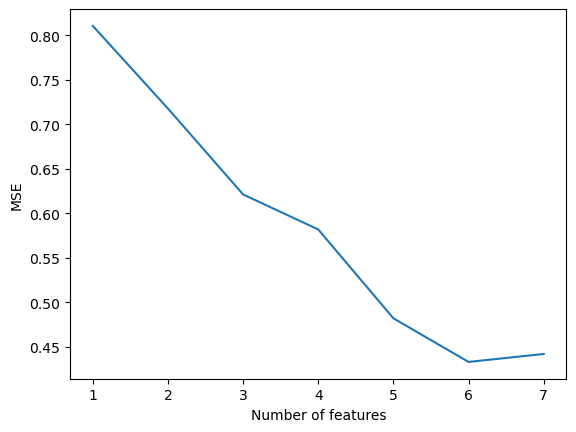

In [19]:
import matplotlib.pyplot as plt
plt.plot(tune_select_scale_knn.cv_results_['param_select__k'].data, -tune_select_scale_knn.cv_results_['mean_test_score'])
plt.ylabel('MSE')
plt.xlabel('Number of features')
plt.show()

But the important result is the evaluation of the model on test

In [20]:
from sklearn.metrics import mean_squared_error

predictions_test = tune_select_scale_knn.predict(X_test)
np.sqrt(mean_squared_error(y_test, predictions_test))

0.6657180265114533